# Politicians on Wikipedia

<img src="imgs/wikipedia.jpg">

# Required Libraries

In [1]:
import pandas as pd
import numpy as np
import wikipedia
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import wordcloud
from sklearn.feature_extraction import text
warnings.filterwarnings("ignore")
%matplotlib inline

# Methods to be used

In [2]:
def get_top(data, sort_by, gender="all", top_x=10):
    """ Returns top_x rows of dataframe sorted by column {sorted_by}
    """
    if gender == "female":
        data = data[data["gender"] == "female"]
    if gender == "male":
        data = data[data["gender"] == "male"]

    return data.sort_values(sort_by,ascending=False).head(top_x)[["WikiURL", sort_by]]


def distribution_plot(data, column, gender="all", x_scale="linear", y_scale="linear"):
    """ Plots a distribution, for specified column, with the possibility of filtering by gender
    """
    if gender != "all":
        data = data[data["gender"] == gender]
    grid = sns.distplot(data[column])       
#     grid.set(xscale="log")

def flatten(data, col):
    f_list = [item for sublist in data[col].values for item in sublist]
    return f_list

def wordcloud_col(data, gender = "female", col = "occupation"):
    """ Plots a wordcloud from text contained in specified column
    """
    if gender == "female":
        data = data[data["gender"] == "female"]
    if gender == "male":
        data = data[data["gender"] == "male"]
        
    lst = flatten(data, col)
    if col == "occupation":
        lst = [i for i in lst if i != "politician"] 
    counts = Counter(lst)
    wc = wordcloud.WordCloud(scale=1, width=800, height=400, background_color="white").generate_from_frequencies(counts)
    plt.figure( figsize=(16,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
def bar_col(data, gender="female", col = "party"):
    """ Plots a bar chart for values in specified column
    """
    if gender == "female":
        data = data[data["gender"] == "female"]
    if gender == "male":
        data = data[data["gender"] == "male"]
        
    lst = flatten(data, col)
    if col == "occupation":
        lst = [i for i in lst if i != "politician"] 
        
    counts = Counter(lst).most_common(10)
    if col == "nationality":
        counts = Counter(lst).most_common(11)
        counts = counts[1:]
    df = pd.DataFrame(counts, columns=['label', 'value'])
    sns.barplot(df["value"], df["label"])
    
def word_cloud_txt(df):
    wc = wordcloud.WordCloud(width=800, height=400).generate(" ".join(df["page_content"].values))
    plt.figure( figsize=(16,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
def plot_gender_over_time(data):
    """ Plots how many items show up over time and colours them differently by gender
    """
    lst = []
    for year in sorted(data["entered"].unique()):
        df = data[data["entered"] == year]
        counts = df["gender"].value_counts().to_dict()
        if "female" in counts.keys():
            lst.append([year, counts["male"], counts["female"]])
        else:
            lst.append([year, counts["male"], 0])
    df = pd.DataFrame(lst, columns = ["year", "males", "females"])
    df = pd.melt(df, id_vars=["year"], value_vars=["males", "females"])
    # print(df)
    g = sns.factorplot(x="year", y="value", hue='variable', data=df)
    g.set_xticklabels(rotation=90)
    
def add_page_content(df,gender):
    """ Returns contents of wikipedia pages from the dataframe
    """
    df = df[df["gender"] == gender]
    df["page_content"] = df["WikiURL"].apply(lambda x: page_content(x))
    return df

def page_content(url):
    try:
        return wikipedia.page(url.split("/")[-1]).content.replace("\n","").replace("==", "")
    except:
        return ""

def add_doc_length(df):
    df["n_terms"] = df["page_content"].apply(lambda x: len(x))
    return df

def print_wikipage_gist(page_name):
    """ Fetches specified Wiki page and prints, title, url, summary, and first 10 img links
    """
    w = wikipedia.page(page_name)
    print("Title: {} \n".format(w.title))
    print("URL: {} \n".format(w.url))
    print("Page Summary: \n {} \n".format(w.summary))
    print("Links to first 10 images: {} \n".format(w.images[:10]))
    
def filter_graph(G, attribute, value):
    """ Returns a filtered subgraph containing nodes with specified attribute
        Input parameters:
        1. G - graph
        2. attribute - filter by this attribute: {gender, occupation, party, nationality}
        3. value - filter by this value, for example 'female' in the case of gender 
    """
    if attribute == "gender":
        return G.subgraph( [n for n,attrdict in G.node.items() if attrdict['gender'] == value] )
    else:
        return G.subgraph( [n for n,attrdict in G.node.items() if value in attrdict[attribute]] )
    
def plot_graph(data_source = "data/2016_12_dir_dir", gender="all"):
    graph = nx.read_gpickle(data_source)
    if gender != "all":
        fg = filter_graph(graph, "gender", gender)
        plt.figure(figsize=(16, 12))
        nx.draw(fg,edge_color='b')
    else:
        plt.figure(figsize=(16, 12))
        nx.draw(graph,edge_color='b')

# Loading Data

In [3]:
data = pd.read_pickle("data/german_politicians")

In [4]:
data.head()

,WikiURL,ID,gender,name,party,nationality,entered,occupation,out_degree,in_degree,eig_central,views
7,http://en.wikipedia.org/wiki/Otto_Hoetzsch,427,male,[ hoetzsch otto ],[],[german],2011,[politician],1,0,2.021104e-19,1652.0
113,http://en.wikipedia.org/wiki/Adolf_Grimme,4123,male,"[ adolf grimme , grimme adolf ]",[],[german],2012,[politician],3,2,2.530002e-05,2376.0
127,http://en.wikipedia.org/wiki/Heinz_Jost,4787,male,[ jost heinz ],[],[german],2009,"[nazism, politician]",4,0,-1.456437e-19,32143.0
132,http://en.wikipedia.org/wiki/Heinz_Neukirchen,4960,male,"[ heinz neukirchen , neukirchen heinz ]",[],[german],2009,[politician],1,1,9.096369e-08,2268.0
158,http://en.wikipedia.org/wiki/Wilhelm_von_Bismarck,5619,male,"[ wilhelm , wilhelm otto albrecht von bismarc...",[],[german],2011,[politician],2,2,7.461692e-04,19536.0


In [5]:
print("Columns of out dataset:\n")
[print(i) for i in data.columns]

Columns of out dataset:

WikiURL
ID
gender
name
party
nationality
entered
occupation
out_degree
in_degree
eig_central
views


[None, None, None, None, None, None, None, None, None, None, None, None]

In [6]:
data.gender.value_counts()

male      1136
female     171
Name: gender, dtype: int64

# Gender distribution

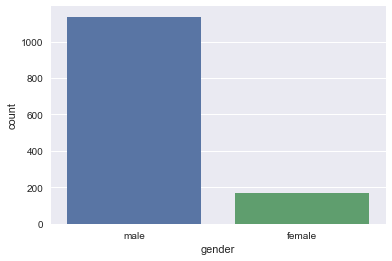

In [7]:
sns.countplot(x="gender", data=data)

# Politicians "entering" Wikipedia over time by gender

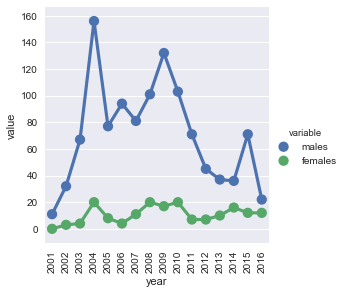

In [8]:
plot_gender_over_time(data)

# Wordcloud of professions (Female politicians)

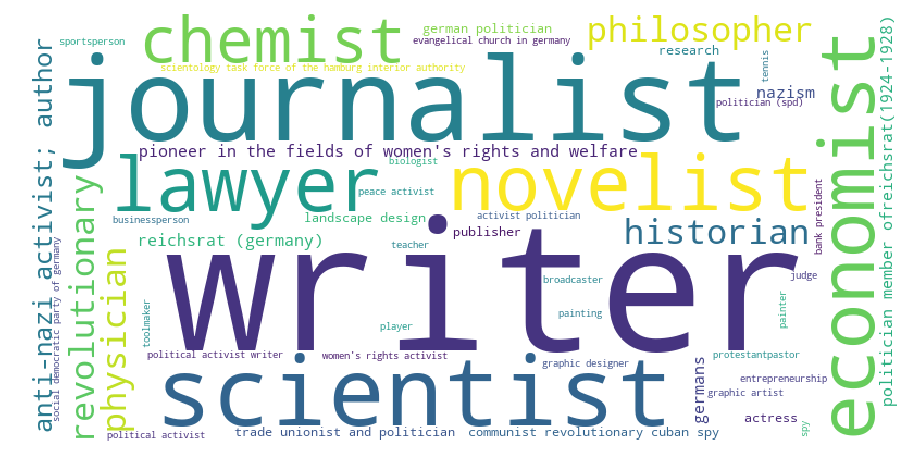

In [9]:
wordcloud_col(data, gender="female")

# Wordcloud of professions (Male politicians)

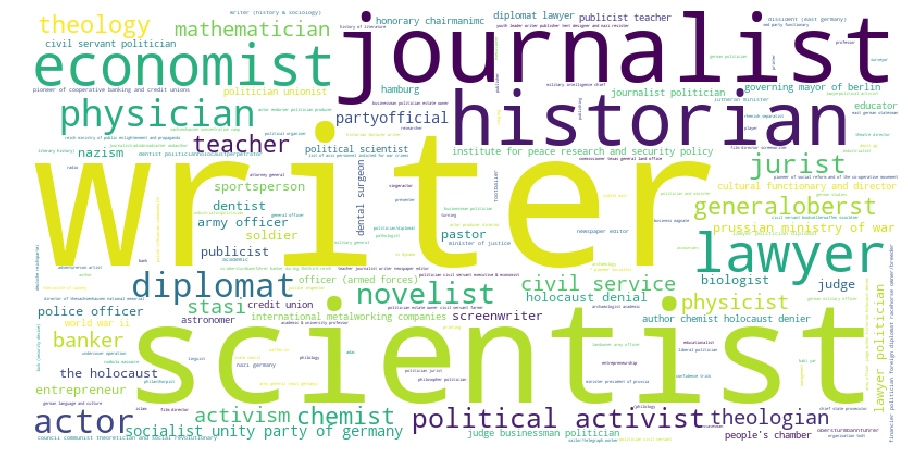

In [10]:
wordcloud_col(data, gender="male")

# Most common professions

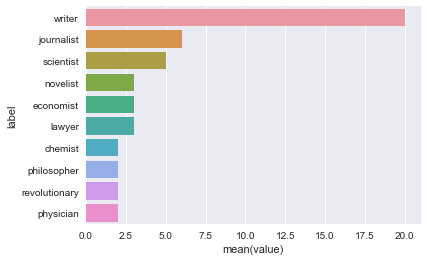

In [11]:
bar_col(data, gender="female", col="occupation")

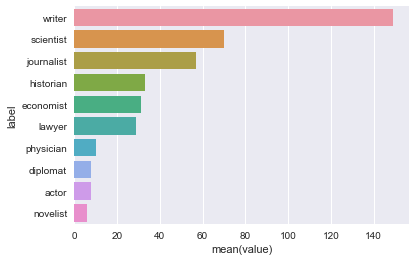

In [12]:
bar_col(data, gender="male", col="occupation")

# Most frequent parties

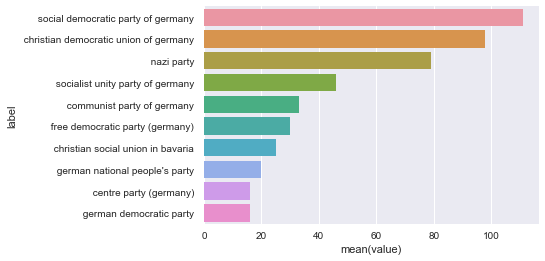

In [13]:
bar_col(data, gender="male", col="party")

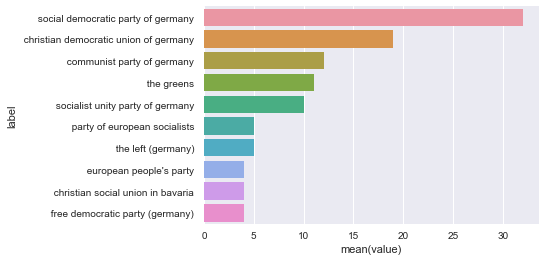

In [14]:
bar_col(data, gender="female", col="party")

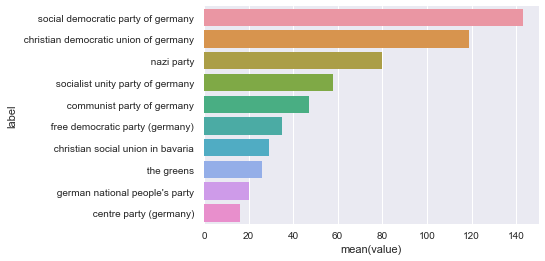

In [15]:
bar_col(data, gender="all", col="party")

# Secondary Nationalities 

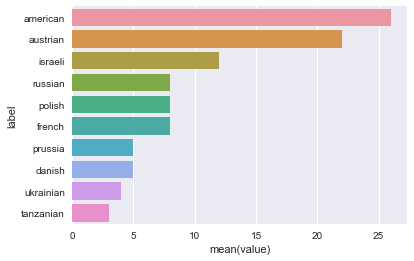

In [16]:
bar_col(data, gender="all", col="nationality")

# How networks are formed

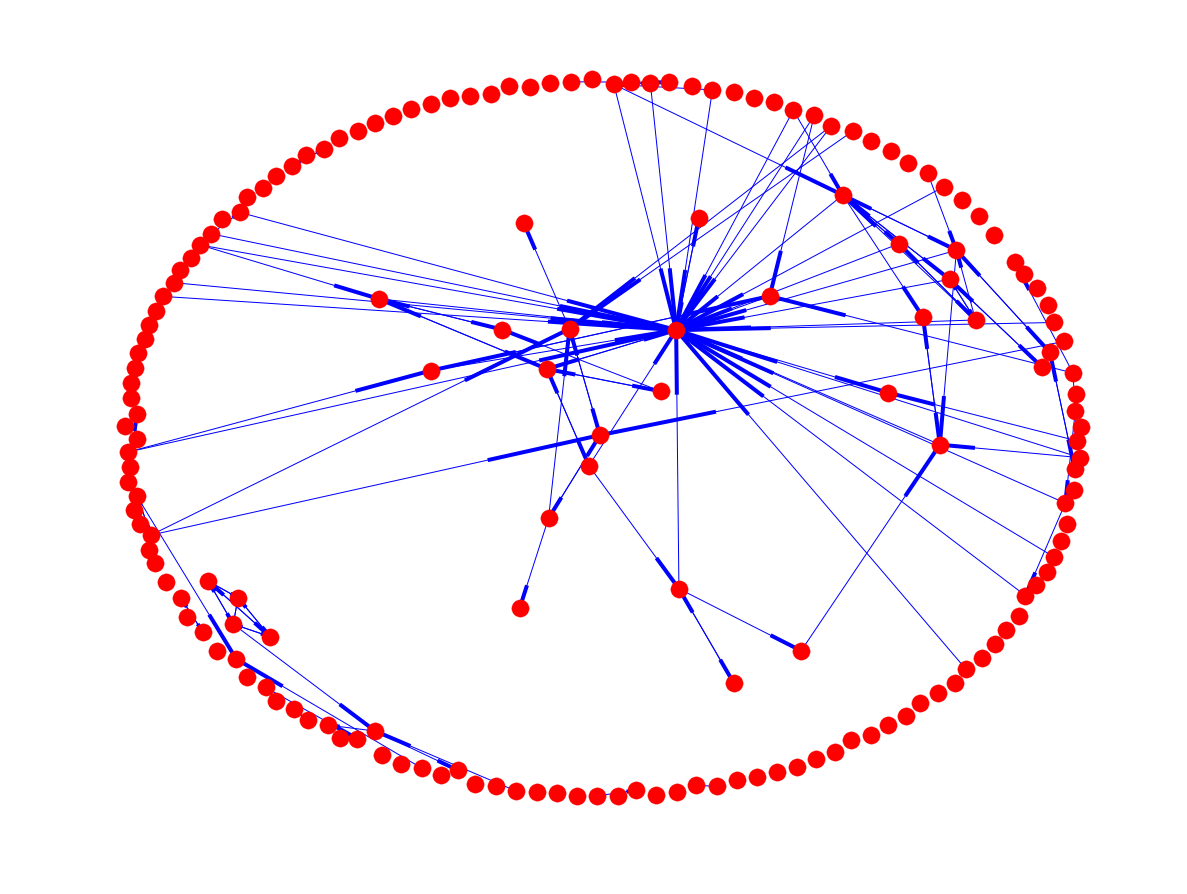

In [17]:
plot_graph(gender="female")

# Most links from other polititians

In [18]:
get_top(data, "in_degree", gender="female", top_x=5)

,WikiURL,in_degree
262,http://en.wikipedia.org/wiki/Angela_Merkel,205
5490,http://en.wikipedia.org/wiki/Rosa_Luxemburg,53
16937,http://en.wikipedia.org/wiki/Hannelore_Kraft,20
19808,http://en.wikipedia.org/wiki/Ursula_von_der_Leyen,19
25919,http://en.wikipedia.org/wiki/Clara_Zetkin,16


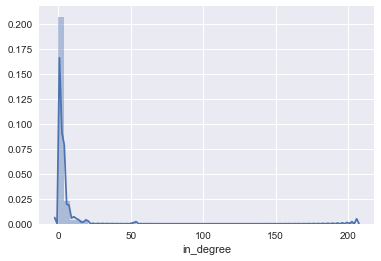

In [19]:
# sns.countplot(x="gender", data=data)
distribution_plot(data, gender="female",column="in_degree")

# Most links to other politicians

In [20]:
get_top(data, "out_degree", gender="female", top_x=5)

,WikiURL,out_degree
262,http://en.wikipedia.org/wiki/Angela_Merkel,51
25953,http://en.wikipedia.org/wiki/Sabine_Leutheusse...,24
13584,http://en.wikipedia.org/wiki/Heidemarie_Wieczo...,24
16937,http://en.wikipedia.org/wiki/Hannelore_Kraft,20
5490,http://en.wikipedia.org/wiki/Rosa_Luxemburg,19


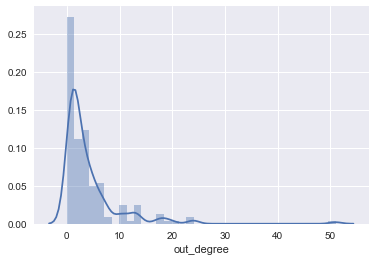

In [21]:
distribution_plot(data, gender="female",column="out_degree")

# Number of views

In [22]:
get_top(data, "views", gender="female",top_x=5)

,WikiURL,views
262,http://en.wikipedia.org/wiki/Angela_Merkel,2404469.0
5490,http://en.wikipedia.org/wiki/Rosa_Luxemburg,396307.0
27562,http://en.wikipedia.org/wiki/Frauke_Petry,307116.0
19808,http://en.wikipedia.org/wiki/Ursula_von_der_Leyen,119953.0
14177,http://en.wikipedia.org/wiki/Ulrike_Meinhof,113341.0


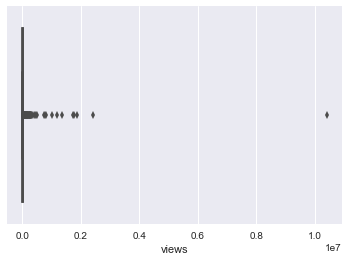

In [23]:
sns.boxplot(data["views"])

# One variable could explain a nother

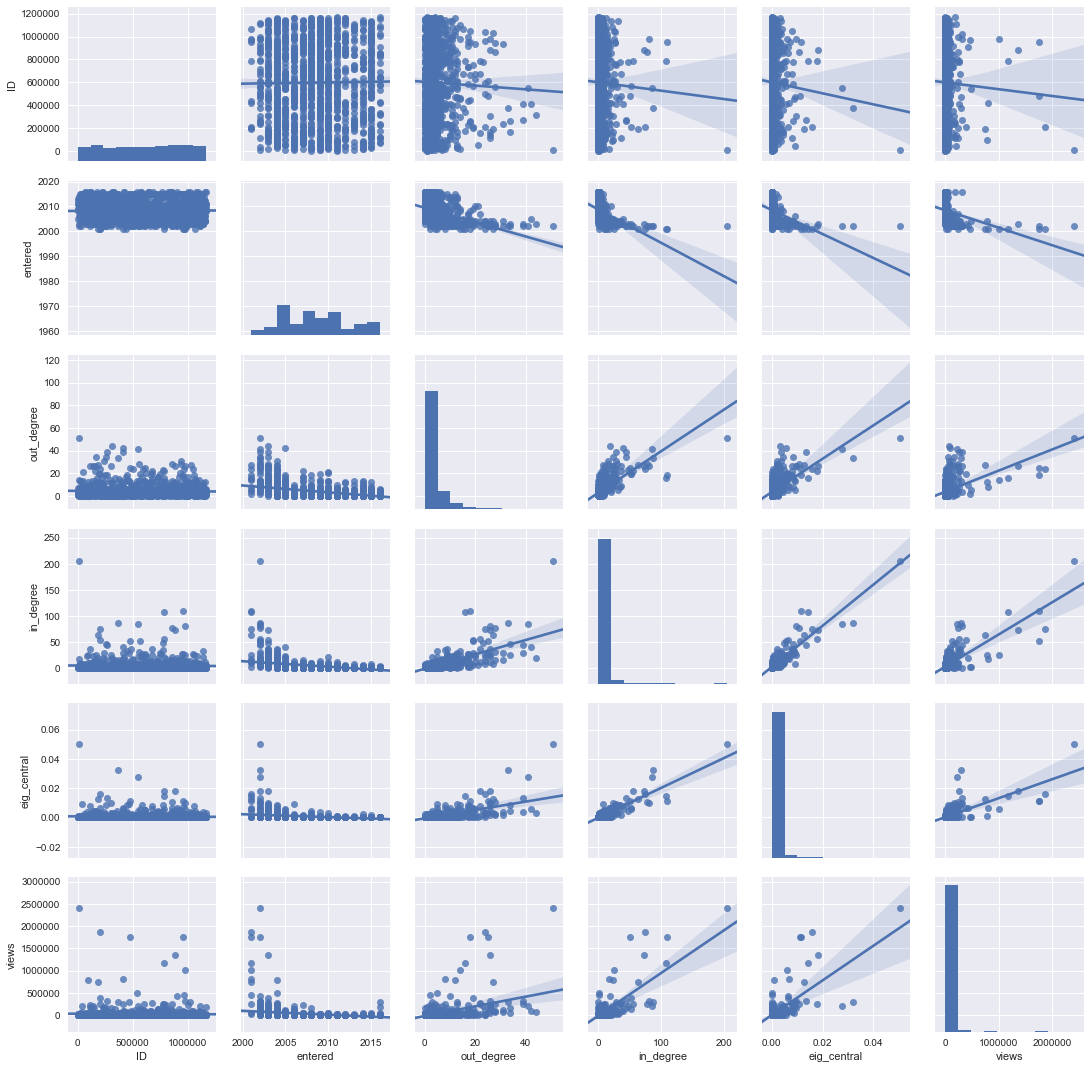

In [24]:
data2 = data.drop(4526) # removing the outlier
data2
sns.pairplot(data2, kind='reg')

# How does this look when we take gender into account?

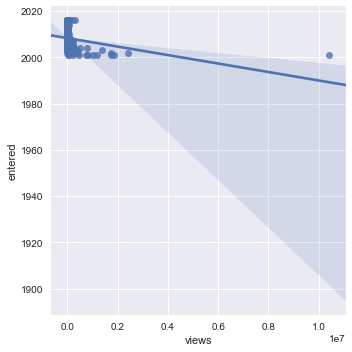

In [25]:
sns.lmplot("views","entered",data=data)

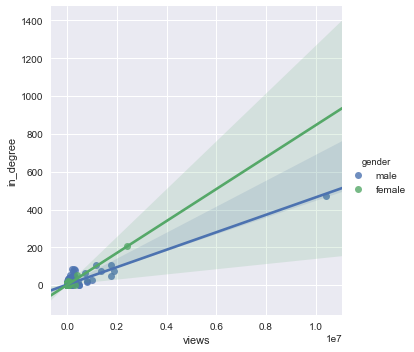

In [26]:
sns.lmplot("views","in_degree", hue="gender", data=data)

# Using the Wikipedia API

 <img src="imgs/api.png">

# Example

In [27]:
wiki_page = wikipedia.page("Barack_Obama")

#### Page Title

In [28]:
wiki_page.title

'Barack Obama'

#### Page URL

In [29]:
wiki_page.url

'https://en.wikipedia.org/wiki/Barack_Obama'

#### Images on Page (first 10)

In [30]:
wiki_page.images[:10]

['https://upload.wikimedia.org/wikipedia/commons/a/a5/20090124_WeeklyAddress.ogv',
 'https://upload.wikimedia.org/wikipedia/commons/2/2b/58th_Presidential_Inaugural_Ceremony_170120-D-BP749-1327.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/f/f1/BarackObamaportrait.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/e/e1/Barack_Obama.ogg',
 'https://upload.wikimedia.org/wikipedia/commons/7/70/Barack_Obama_Iraq_2006.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/3/32/Barack_Obama_addresses_joint_session_of_Congress_2009-02-24.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/b/b8/Barack_Obama_and_Bill_Clinton.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/7/76/Barack_Obama_and_Matteo_Renzi_October_2016%2C_1.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/4/42/Barack_Obama_at_Cairo_University_cropped.jpg',
 'https://upload.wikimedia.org/wikipedia/commons/8/83/Barack_Obama_foreign_trips.svg']

#### Page Summary

In [31]:
wiki_page.summary

'Barack Hussein Obama II ( ( listen); born August 4, 1961) is an American politician who served as the 44th President of the United States from January 20, 2009 to January 20, 2017. The first African American to assume the presidency, he was previously the junior United States Senator from Illinois from 2005 to 2008. Before that, he served in the Illinois State Senate from 1997 until 2004.\nObama was born in 1961 in Honolulu, Hawaii, two years after the territory was admitted to the Union as the 50th state. Raised largely in Hawaii, Obama also spent one year of his childhood in Washington State and four years in Indonesia. After graduating from Columbia University in New York City in 1983, he worked as a community organizer in Chicago. In 1988 Obama enrolled in Harvard Law School, where he was the first black president of the Harvard Law Review. After graduation, he became a civil rights attorney and professor and taught constitutional law at the University of Chicago Law School from 1

#### Page Content

In [32]:
number_char = 200
wiki_page.content[:number_char] #this is yust the first 200 characters

'Barack Hussein Obama II ( ( listen); born August 4, 1961) is an American politician who served as the 44th President of the United States from January 20, 2009 to January 20, 2017. The first African A'

## Try it out on a page interesting to you

In [33]:
print_wikipage_gist("Star_Wars")

Title: Star Wars 

URL: https://en.wikipedia.org/wiki/Star_Wars 

Page Summary: 
 Star Wars is an American epic space opera media franchise, centered on a film series created by George Lucas. It depicts the adventures of various characters "a long time ago in a galaxy far, far away".
The franchise began in 1977 with the release of the film Star Wars (later subtitled Episode IV: A New Hope in 1981), which became a worldwide pop culture phenomenon. It was followed by the successful sequels The Empire Strikes Back (1980) and Return of the Jedi (1983); these three films constitute the original Star Wars trilogy. A prequel trilogy was released between 1999 and 2005, which received mixed reactions from both critics and fans. A sequel trilogy began in 2015 with the release of Star Wars: The Force Awakens and continued in 2017 with the release of Star Wars: The Last Jedi. The first eight films were nominated for Academy Awards (with wins going to the first two films released) and have been com

# Content of Wiki Pages has been downloaded (to save time)

In [34]:
f_content = pd.read_pickle("data/ctnt_f_politicians")
m_content = pd.read_pickle("data/ctnt_m_politicians")

In [35]:
f_content.head()

,WikiURL,gender,name,party,nationality,entered,occupation,out_degree,in_degree,eig_central,views,page_content,n_terms
262,http://en.wikipedia.org/wiki/Angela_Merkel,female,[ angela merkel ],"[ democratic awakening , christian democratic...",[german],2002,"[politician, chemist, scientist]",51,205,5.054432e-02,2404469.0,Angela Dorothea Merkel (; German: [aŋˈɡeːla ˈm...,40200
575,http://en.wikipedia.org/wiki/Vicky_Leandros,female,[ vicky leandros ],[],[german],2008,[politician],0,1,-2.036547e-19,59260.0,Vassiliki Papathanasiou (bornGreek: Βασιλική Π...,13222
926,http://en.wikipedia.org/wiki/Marieluise_Beck,female,[ marieluise beck ],[ the greens ],[german],2014,[politician],13,4,1.044176e-05,3098.0,Marieluise Beck (born 25 June 1952 in Bramsche...,6446
1138,http://en.wikipedia.org/wiki/Annkathrin_Kammeyer,female,"[ annkathrin kammeyer , kammeyer annkathrin ]",[ social democratic party of germany ],[german],2012,[politician],1,0,-1.044400e-19,1340.0,Annkathrin Kammeyer (born 12 January 1990) is ...,1241
1408,http://en.wikipedia.org/wiki/Britta_Böhler,female,"[ britta böhler , bohler britta ]",[ groenlinks ],[german],2005,[politician],5,1,3.184073e-06,4320.0,Britta Böhler (17 July 1960 in Freiburg im Bre...,5007


# Wordcloud Female Politicians

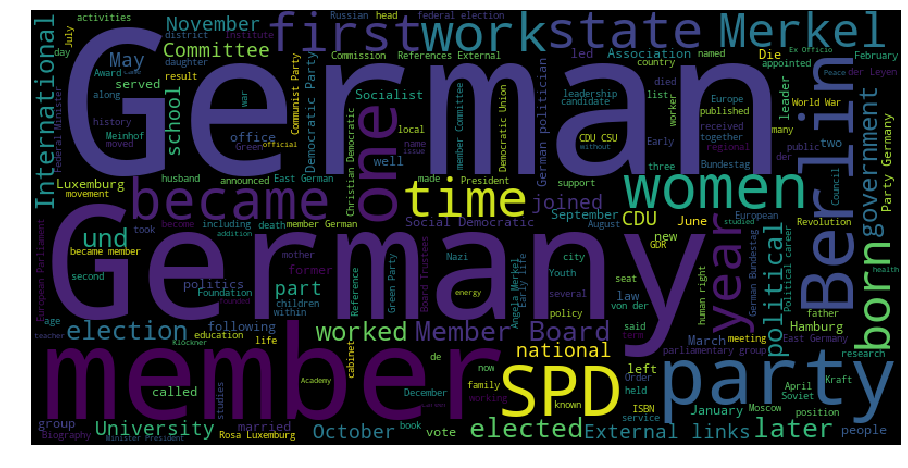

In [36]:
word_cloud_txt(f_content)

# Wordcloud Male Politicians

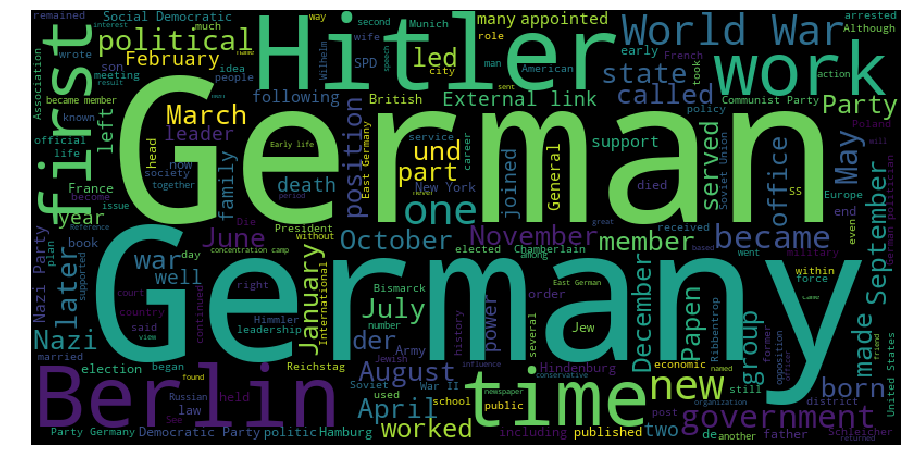

In [37]:
word_cloud_txt(m_content)

# Page length (number of words) Male vs Female

In [38]:
m_content["n_terms"].describe()

count      1136.000000
mean       6356.247359
std       11212.024380
min           0.000000
25%        1674.500000
50%        3461.500000
75%        6655.250000
max      140284.000000
Name: n_terms, dtype: float64

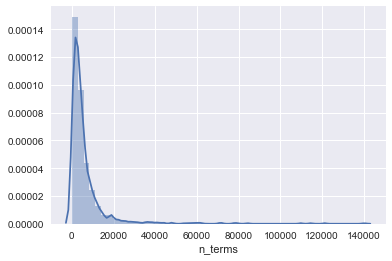

In [39]:
sns.distplot(m_content["n_terms"])

In [40]:
f_content["n_terms"].describe()

count      171.000000
mean      4784.608187
std       6029.411471
min          0.000000
25%       1481.500000
50%       3139.000000
75%       6124.500000
max      46102.000000
Name: n_terms, dtype: float64

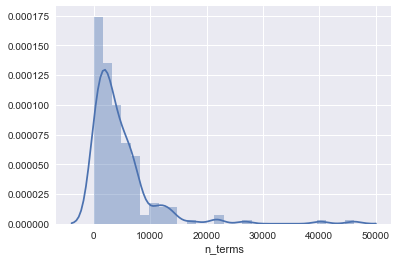

In [41]:
sns.distplot(f_content["n_terms"])